## Wykorzystane moduły

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sweetviz as sv
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split

from data_processing.utils import encode_target, binary_encode, one_hot_encode, split_date

In [3]:
np.random.seed(42)

## Załadawanie i wstępny przegląd danych

In [4]:
dataset = pd.read_csv('data/accepted_2007_to_2018Q4.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
sum(dataset.loan_status.isna())

33

In [6]:
dataset = dataset[~dataset.loan_status.isna()]
dataset = dataset[dataset.loan_status != 'Current']

In [7]:
dataset.shape

(1382351, 151)

Kodowanie zmiennej objaśnianej zgodnie z poleceniem:

In [8]:
dataset = encode_target(dataset, predicate=lambda df: (df.loan_status == 'Fully Paid').astype(int))

In [9]:
dev_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=True, stratify=dataset.target)

In [10]:
dev_data.to_pickle('data/dev_dataset.pkl')
test_data.to_pickle('data/test_dataset.pkl')

Wygenerowano prosty raport celem wstępnego odrzucenia niektórych zmiennych. W szczególności tych zawierających przechylony rozkład (dominacja jednej wartości - w szczegolności 0), zawierających zbyt dużo wartości nan oraz zmiennych kategorycznych o zbyt dużej liczności wartości.

In [11]:
profile = ProfileReport(dev_data, title="Pandas Profiling Report", minimal=True)
profile.to_file("data_processing/data_reports/profiling_report.html")

Summarize dataset:   0%|          | 0/162 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

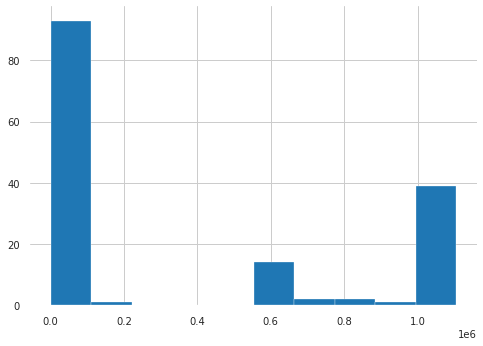

In [12]:
dev_data.isna().sum().hist()
plt.show()

W ramach realizowanego zadania trudno będzie obsłużyć brakujące wartości bez dogłębnego zrozumienia znaczenia atrybutu, zwłaszcze jeśli tych wartości jest zdecydowana większość - usunięto kolumny mające więcej niż 10% brakujących wartości.

In [13]:
dev_data = dev_data.dropna(axis=1, thresh=int(0.9 * len(dev_data)))

dev_data.shape

Usunięto nieprzetworzoną zmienną objaśnianą oraz atrybuty ocenione jako zbędne na potrzeby modelowania (string, zbyt dużo możliwych wartości dla zmiennych kategorycznych, zbyt duża dominacja obserwacji dla jednej wartości zmiennej kategorycznej etc.)

In [15]:
to_drop = [
           'loan_status', 'id', 'emp_title', 'pymnt_plan', 'title', 'zip_code', 'policy_code', 'url'
]
dev_data = dev_data.drop(columns=to_drop)

In [16]:
dev_data.isna().sum()

loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
                              ...  
total_il_high_credit_limit    56225
hardship_flag                     0
disbursement_method               0
debt_settlement_flag              0
target                            0
Length: 85, dtype: int64

In [17]:
na_columns = dev_data.isna().sum()
na_columns[na_columns > 24]

emp_length                    65376
dti                             324
revol_util                      750
last_pymnt_d                   1960
last_credit_pull_d               39
collections_12_mths_ex_med      116
tot_coll_amt                  56225
tot_cur_bal                   56225
total_rev_hi_lim              56225
acc_open_past_24mths          39985
avg_cur_bal                   56243
bc_open_to_buy                51462
bc_util                       52101
chargeoff_within_12_mths        116
mo_sin_old_il_acct            87697
mo_sin_old_rev_tl_op          56226
mo_sin_rcnt_rev_tl_op         56226
mo_sin_rcnt_tl                56225
mort_acc                      39985
mths_since_recent_bc          50692
num_accts_ever_120_pd         56225
num_actv_bc_tl                56225
num_actv_rev_tl               56225
num_bc_sats                   46877
num_bc_tl                     56225
num_il_tl                     56225
num_op_rev_tl                 56225
num_rev_accts               

In [18]:
to_drop = [
           'earliest_cr_line', 
           'pub_rec', 
           'revol_util', 
           'bc_open_to_buy', 
           'mo_sin_old_il_acct', 
           'mo_sin_old_rev_tl_op', 
           'mo_sin_rcnt_rev_tl_op', 
           'mo_sin_rcnt_tl',
           'mths_since_recent_bc',
           'num_actv_bc_tl',
           'num_actv_rev_tl',
           'num_bc_sats',
           'num_bc_tl',
           'num_il_tl',
           'num_op_rev_tl',
           'num_rev_accts',
           'num_rev_tl_bal_gt_0',
           'num_sats',
           'num_tl_120dpd_2m',
           'num_tl_30dpd',
           'num_tl_90g_dpd_24m',
           'num_tl_op_past_12m',
           'pub_rec_bankruptcies',
           'total_bal_ex_mort',
           'total_bc_limit',
           'total_rec_late_fee'
           ]
dev_data = dev_data.drop(columns=to_drop)

In [19]:
date_features = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']

dev_data = split_date(dev_data, date_features, '-', ['month', 'year'])

In [20]:
dev_data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,revol_bal,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_util,chargeoff_within_12_mths,delinq_amnt,mort_acc,num_accts_ever_120_pd,pct_tl_nvr_dlq,percent_bc_gt_75,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,target,issue_dmonth,issue_dyear,last_pymnt_dmonth,last_pymnt_dyear,last_credit_pull_dmonth,last_credit_pull_dyear
93313,12000.0,12000.0,12000.0,36 months,8.18,377.04,B,B1,8 years,MORTGAGE,36000.0,Not Verified,credit_card,IL,26.80,0.0,715.0,719.0,2.0,15.0,8356.0,24.0,w,0.0,0.0,13575.757156,13575.76,12000.0,1575.76,0.0,0.0,326.68,659.0,655.0,0.0,Individual,0.0,0.0,28673.0,35900.0,4.0,2048.0,29.9,0.0,0.0,0.0,0.0,95.8,14.3,0.0,59900.0,24000.0,N,Cash,N,1,Oct,2015,Oct,2018,Oct,2018
644892,14000.0,14000.0,14000.0,36 months,5.32,421.61,A,A1,10+ years,MORTGAGE,61000.0,Not Verified,small_business,KS,16.86,0.0,790.0,794.0,0.0,19.0,10064.0,30.0,w,0.0,0.0,14689.090727,14689.09,14000.0,689.09,0.0,0.0,10028.62,749.0,745.0,0.0,Individual,0.0,0.0,98208.0,103800.0,5.0,5169.0,10.6,0.0,0.0,2.0,0.0,100.0,0.0,0.0,201039.0,33999.0,N,Cash,N,1,Jul,2017,Jul,2018,Sep,2018
682290,4500.0,4500.0,4500.0,36 months,11.99,149.45,C,C1,< 1 year,RENT,35000.0,Source Verified,debt_consolidation,IN,19.72,0.0,685.0,689.0,1.0,8.0,3281.0,28.0,f,0.0,0.0,5017.039275,5017.04,4500.0,517.04,0.0,0.0,3224.94,709.0,705.0,0.0,Individual,0.0,251.0,90850.0,10400.0,8.0,11356.0,41.5,0.0,0.0,0.0,0.0,88.9,33.3,0.0,105019.0,94619.0,N,Cash,N,1,Jun,2016,Jul,2017,Jan,2019
1778326,5400.0,5400.0,5400.0,36 months,7.90,168.97,A,A4,2 years,RENT,57783.0,Source Verified,debt_consolidation,CA,15.74,0.0,720.0,724.0,0.0,10.0,12112.0,19.0,w,0.0,0.0,6046.230000,6046.23,5400.0,646.23,0.0,0.0,1484.04,774.0,770.0,0.0,Individual,0.0,0.0,25004.0,16400.0,1.0,2500.0,83.9,0.0,0.0,0.0,0.0,100.0,66.7,0.0,48658.0,32258.0,N,Cash,N,1,Nov,2013,Mar,2016,Mar,2016
1994376,10000.0,10000.0,10000.0,60 months,12.79,226.46,C,C1,< 1 year,MORTGAGE,34000.0,Source Verified,credit_card,NC,6.81,0.0,675.0,679.0,0.0,16.0,7430.0,26.0,w,0.0,0.0,12174.601017,12174.60,10000.0,2174.60,0.0,0.0,7181.83,714.0,710.0,0.0,Individual,0.0,2080.0,59520.0,29800.0,5.0,3720.0,33.9,0.0,0.0,2.0,0.0,100.0,0.0,0.0,68147.0,38347.0,N,Cash,N,1,Aug,2016,Jul,2018,Aug,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149660,7000.0,7000.0,7000.0,36 months,15.61,244.76,D,D1,10+ years,OWN,20000.0,Verified,credit_card,NY,20.47,0.0,675.0,679.0,2.0,9.0,6674.0,11.0,w,0.0,0.0,8798.926211,8798.93,7000.0,1798.93,0.0,0.0,244.47,679.0,675.0,0.0,Individual,0.0,225.0,6674.0,15300.0,4.0,742.0,81.7,0.0,0.0,1.0,1.0,90.9,66.7,0.0,15300.0,0.0,N,Cash,N,1,Sep,2015,Sep,2018,Sep,2018
692722,19200.0,19200.0,19200.0,60 months,8.39,392.91,B,B1,10+ years,MORTGAGE,86000.0,Not Verified,debt_consolidation,FL,6.96,0.0,680.0,684.0,1.0,10.0,16200.0,26.0,w,0.0,0.0,19453.010000,19453.01,19200.0,253.01,0.0,0.0,19082.47,689.0,685.0,0.0,Individual,0.0,0.0,217442.0,27500.0,3.0,21744.0,56.5,0.0,0.0,2.0,0.0,100.0,40.0,0.0,231070.0,0.0,N,Cash,N,1,May,2016,Aug,2016,Aug,2018
17462,6000.0,6000.0,6000.0,36 months,13.18,202.69,C,C3,NaN,OWN,23000.0,Verified,debt_consolidation,NY,32.20,0.0,670.0,674.0,3.0,12.0,5486.0,14.0,w,0.0,0.0,7131.861870,7131.86,6000.0,1131.86,0.0,0.0,2478.78,689.0,685.0,0.0,Individual,0.0,5807.0,1510

In [21]:
dev_data.shape

(1105880, 62)

## Eksploracyjna analiza danych

Bo wstępnym odrzuceniu znacznej części cech, wygenerowano raport sweetviz na potrzeby nieco głębszej analizy poszególnych zmiennych

In [22]:
eda_report = sv.analyze(dev_data)
eda_report.show_html('data_processing/data_reports/EDA_Report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report data_processing/data_reports/EDA_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Na potrzeby zadania dokonano dwóch przykładowych analiz potencjalnego wpływu cechy na predykcję

Analizując stworzony raport stwierdzono że poniższe zmienne ciągłe mogą być wzajemnie zależne, co może oznaczać, iż nie ma potrzeby uwzględniać ich wszystkich w modelowaniu

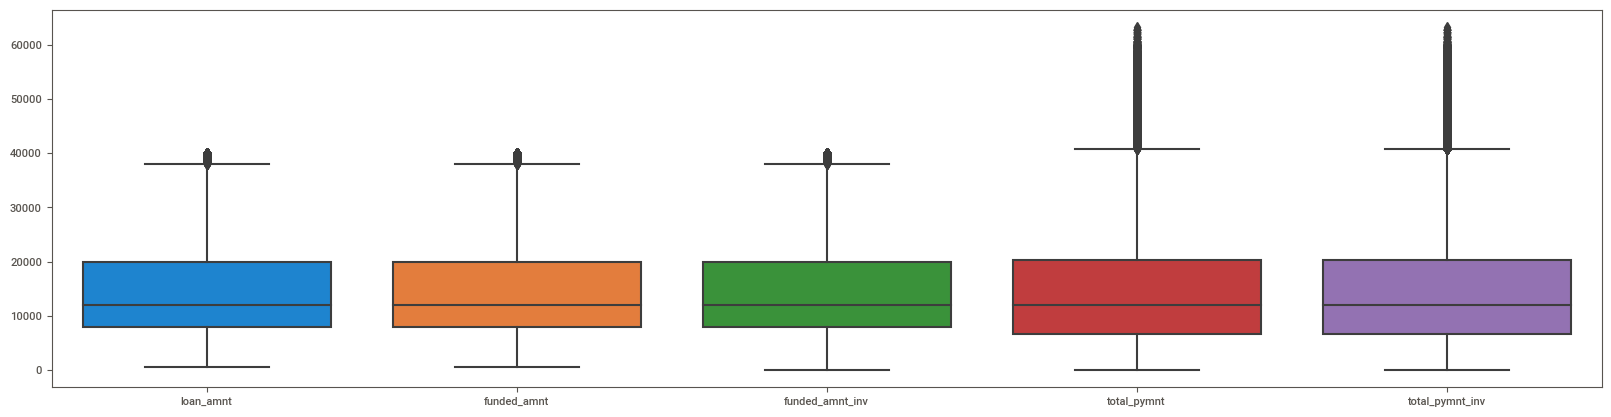

In [23]:
cont_eda_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt', 'total_pymnt_inv']

plt.figure(figsize=(20,5))
sns.boxplot(data=dev_data[cont_eda_features])

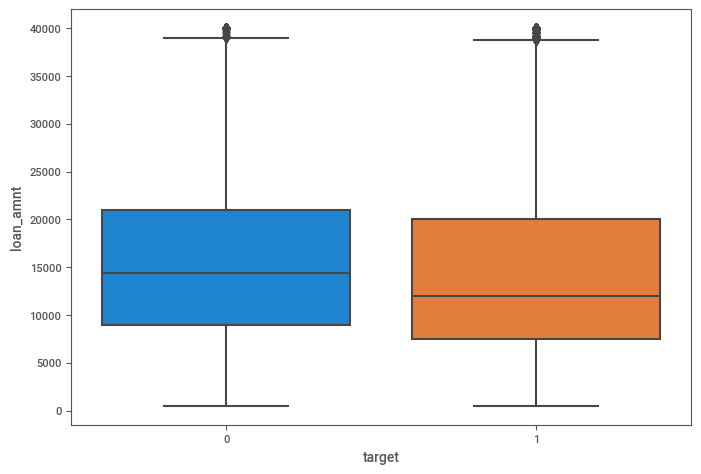

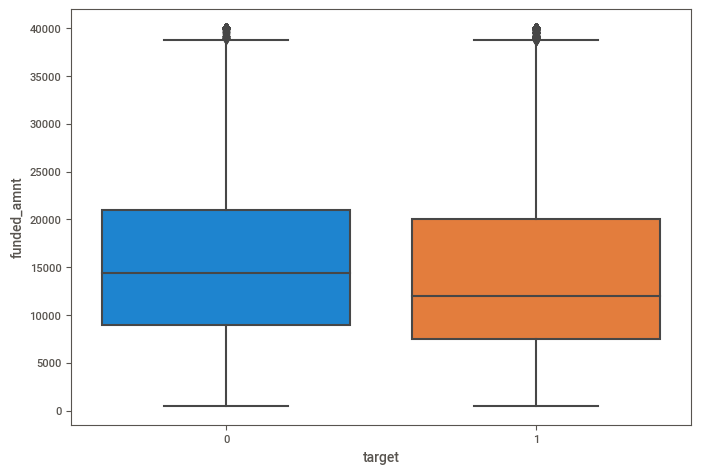

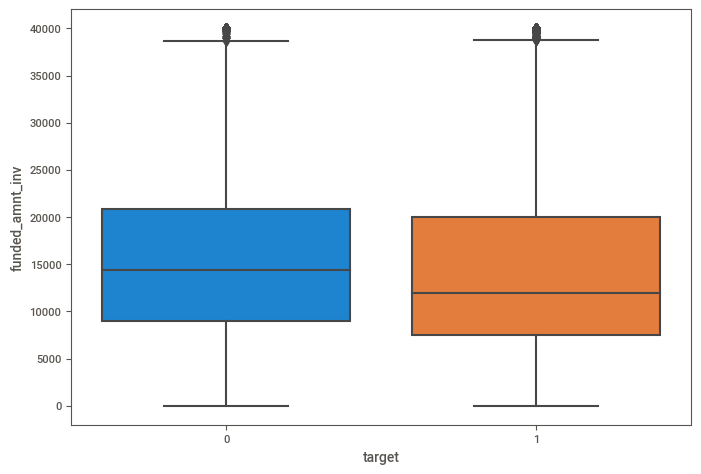

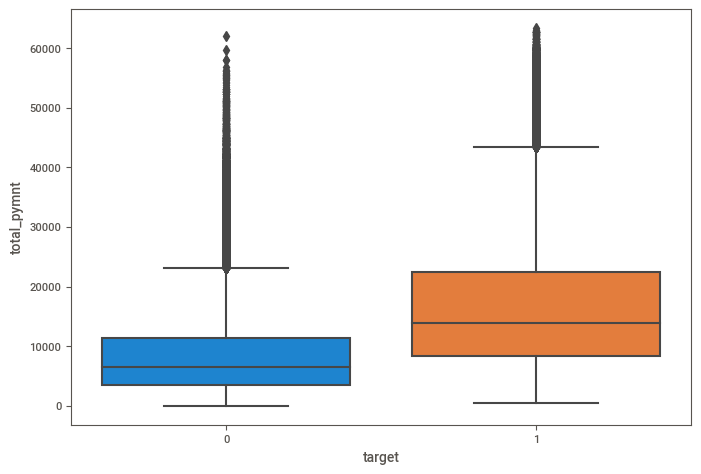

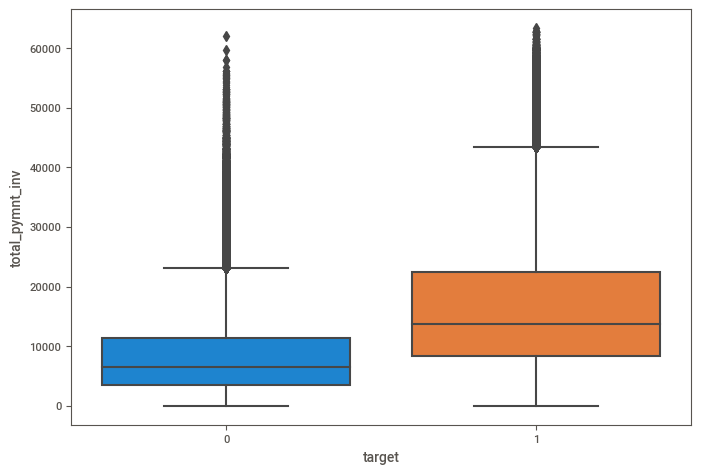

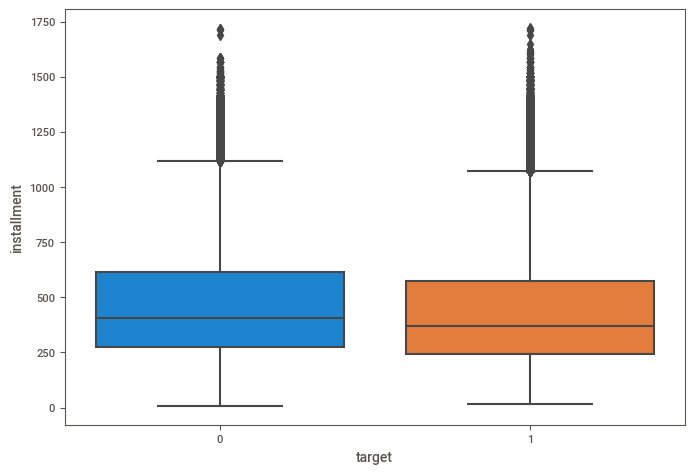

In [24]:
for feat in cont_eda_features + ['installment']:
  sns.boxplot(data=dev_data[[feat, 'target']], x='target', y=feat)
  plt.show()

Uwzględniając zmienną objaśniaoną przy porówaniu rozkładów badanych cech, stwierdzono, iż można bezpiecznie usunąć ['funded_amnt', 'funded_amnt_inv'] (wydaje się to oczywiste w oparciu o nazwy, jednak zgodnie z proponowanym uproszczeniem, nie dokonano dogłębnej analizy znaczenia cech). Usunięto również zmienną installment która była silnie skorelowana z pozostałymi oraz, wydaje się mieć podobny wpływ na zmienną objaśnianą. W przypadku pozostałych zmiennych, wpływ na rozkłady zmiennej objaśnianej wydaje się inny, wobec czego na razie je pozostawiono.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


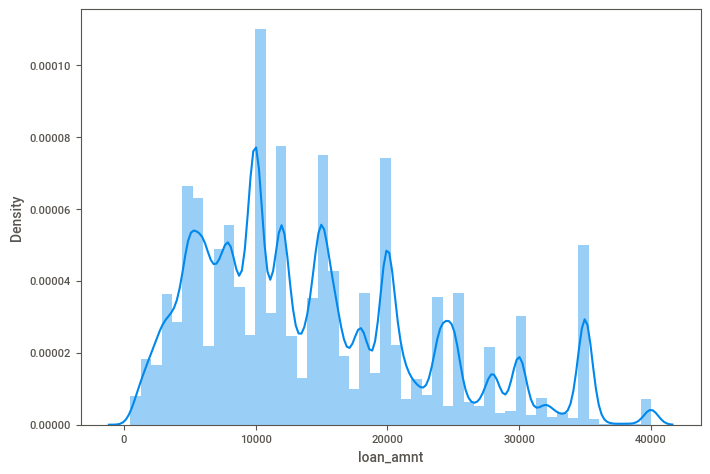

In [25]:
sns.distplot(dev_data.loan_amnt)

Znaczący wpływ wydaje się mieć zmienna określająca wielkość wartości kredytu. Ciekawym jest kształt rozkładu chakrateruzujący się bardzo dużą liczbą esktremów lokalnych. Jednak jest to zrozumiałe - rzadko się zdarza aby ktoś brał kredy na sumę inną niż będącą wielokrotnością 1000. Można by było zastanowaić się czy nie należałoby tej zmiennej zdystkreyzować, jednak ze względu na ograniczony czas realizacji zadania, nie rozważono tej możliwości.

Sprawdzono również znaczenie zmiennej grade z uwzględniemiem powiązanej zmiennej subgrade.

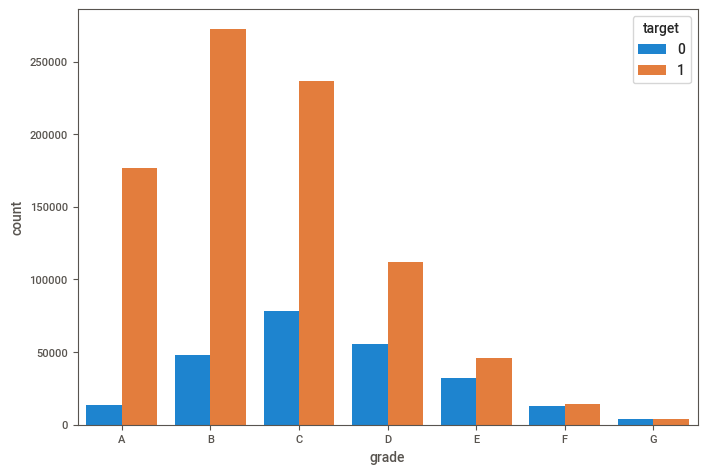

In [26]:
sns.countplot(data=dev_data[['grade', 'target']], x='grade', hue='target', order=sorted(dev_data['grade'].astype(str).unique()))

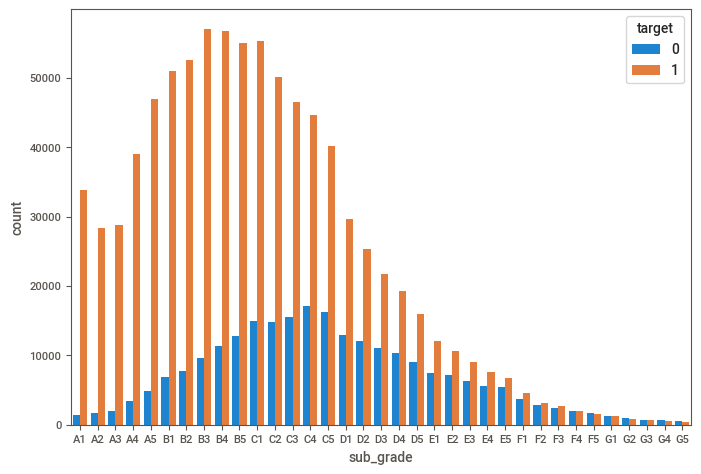

In [27]:
sns.countplot(data=dev_data[['sub_grade', 'target']], x='sub_grade', hue='target', order=sorted(dev_data['sub_grade'].astype(str).unique()))

Obie zmienne wydają się mieć znaczenie dla predykcji. Jednak zmienna subgrade nie wydaje się wnosić dodatkowej wiedzy a uwzględnia dużo większą liczbę kategorii. W zbiorze pozostawiono tylko zmienną grade.

In [28]:
dev_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'open_acc', 'revol_bal', 'total_acc', 'initial_list_status',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mort_acc',
       'num_accts_ever_120_pd', 'pct_tl_nvr_dlq', 'percent_bc_gt_75',
       'tax_liens', 'tot_hi_cred_lim', 'total_il_high_credit_limit',
       'ha

Dokonano kolejnej iteracji przeglądu (bardzo płytiego i szybkiego) opisu zmiennych z uwzględnieniem obliczonych w raporcie zależności. Wybrano kolejne cechy do odrzucenia.

In [29]:
to_drop =  [
            'funded_amnt', 
            'funded_amnt_inv', 
            'total_pymnt_inv', 
            'installment', 
            'sub_grade', 
            'emp_length', 
            'addr_state', 
            'purpose', 
            'fico_range_high',
            'out_prncp',
            'out_prncp_inv',
            'total_rec_prncp',
            'collection_recovery_fee',
            'last_fico_range_high',
            'total_rev_hi_lim',
            'total_acc',
            'tot_cur_bal',
            'tot_hi_cred_lim',
            'percent_bc_gt_75', 
            'issue_dmonth',
            'last_pymnt_dmonth',
            'issue_dyear',
            'last_pymnt_dyear',
            'last_credit_pull_dyear',
            'delinq_2yrs',
            'collections_12_mths_ex_med',
            'tot_coll_amt',
            'chargeoff_within_12_mths',
            'delinq_amnt',
            'mort_acc',
            'num_accts_ever_120_pd',
            'tax_liens',
            'total_il_high_credit_limit'
            ]
dev_data = dev_data.drop(columns=to_drop)

## Ostateczna selekcja cech i przekształcenie zmiennych kategorycznych

In [30]:
dev_data.dtypes

loan_amnt                  float64
term                        object
int_rate                   float64
grade                       object
home_ownership              object
annual_inc                 float64
verification_status         object
dti                        float64
fico_range_low             float64
inq_last_6mths             float64
open_acc                   float64
revol_bal                  float64
initial_list_status         object
total_pymnt                float64
total_rec_int              float64
recoveries                 float64
last_pymnt_amnt            float64
last_fico_range_low        float64
application_type            object
acc_now_delinq             float64
acc_open_past_24mths       float64
avg_cur_bal                float64
bc_util                    float64
pct_tl_nvr_dlq             float64
hardship_flag               object
disbursement_method         object
debt_settlement_flag        object
target                       int64
last_credit_pull_dmo

Zweryfikowano zmienne kategoryczne pod kątem decyzji czy należy je zakodować binarnie czy metodą one-hot. Jednak wcześniej dokonano ostatniej iteracji przeglądu znaczenia cech, aby odrzucić te, które prawdopodbnie (ponowanie, nie zagłębiano się mocno w opisy cech) są ściśle związane ze zmienną objaśnianą - w kontekście badanego problemu pozwalają niemal wprost przewidzieć spłatę kredytu, lub nie są znane przed jej dokonaniem.

In [31]:
to_drop = ['pct_tl_nvr_dlq', 'inq_last_6mths', 'total_pymnt', 'total_rec_int', 'last_pymnt_amnt', 'last_fico_range_low', 'recoveries', 'last_credit_pull_dmonth', 'debt_settlement_flag', 'hardship_flag']

In [32]:
dev_data = dev_data.drop(columns=to_drop)

Zakodowano zmienne kategoryczne

In [35]:
binary_features = ['term', 'initial_list_status', 'application_type', 'disbursement_method']
cat_features = ['grade', 'home_ownership', 'verification_status']

In [36]:
dev_data = one_hot_encode(dev_data, cat_features)

In [37]:
dev_data = binary_encode(dev_data, binary_features)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
dev_data

,loan_amnt,term,int_rate,annual_inc,dti,fico_range_low,open_acc,revol_bal,initial_list_status,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_util,disbursement_method,target,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
93313,12000.0,0,8.18,36000.0,26.80,715.0,15.0,8356.0,1,0,0.0,4.0,2048.0,29.9,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
644892,14000.0,0,5.32,61000.0,16.86,790.0,19.0,10064.0,1,0,0.0,5.0,5169.0,10.6,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
682290,4500.0,0,11.99,35000.0,19.72,685.0,8.0,3281.0,0,0,0.0,8.0,11356.0,41.5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1778326,5400.0,0,7.90,57783.0,15.74,720.0,10.0,12112.0,1,0,0.0,1.0,2500.0,83.9,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1994376,10000.0,1,12.79,34000.0,6.81,675.0,16.0,7430.0,1,0,0.0,5.0,3720.0,33.9,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149660,7000.0,0,15.61,20000.0,20.47,675.0,9.0,6674.0,1,0,0.0,4.0,742.0,81.7,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
692722,19200.0,1,8.39,86000.0,6.96,680.0,10.0,16200.0,1,0,0.0,3.0,21744.0,56.5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
17462,6000.0,0,13.18,23000.0,32.20,670.0,12.0,5486.0,1,0,0.0,5.0,1258.0,40.8,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
119046,28000.0,0,7.89,150000.0,13.05,745.0,9.0,88641.0,0,0,0.0,2.0,64237.0,68.4,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


W wypadku realizacji tego projektu w większym czasie oraz na skalę produkcyjną, rozważonoby możliwość uzupłenienia brakujących wartości aby nie wyrzucać danych. W tym wypadku jednak dokonano uproszczenia i wiersze zawierające komórki nan zostaną usunięte przy modelowaniu, zwłaszcza że nie stanowią one bardzo dużej części zbioru.

In [40]:
dev_data.dropna().shape[0] / dev_data.shape[0]

0.9381180598256592